# Example of using the orm classes

### Imports

In [1]:
from core.core import Project
from core.orm import BoreholeOrm, Base
from utils.io import boreholes_from_files
from striplog import Lexicon, Striplog, Interval, Component, Position, Decor, Legend
from striplog.utils import hex_to_rgb
from matplotlib.colors import ListedColormap
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import omfvista as ov
import pyvista as pv
import omf
from vtk import vtkX3DExporter
from IPython.display import HTML

In [3]:
from core.omf import Borehole3D, striplog_legend_to_omf_legend 

In [4]:
! rm ./tmp/test_orm_db.db

In [5]:
components = [Component({'lithology': 'siltstone', 'colour': 'grey'}),
              Component({'lithology': 'anhydrite'}),
              Component({'lithology': 'sandstone', 'grainsize': 'vf-f', 'colour': 'grey'}),
              Component({'lithology': 'dolomite'}),
              Component({'lithology': 'siltstone', 'colour': 'red'}),
              Component({'lithology': 'limestone'})]
list_of_decors=[]
hatches = ['=', 'x', '.', 's', '=', 'b']
colours = ['#888888', '#882222', '#AAAAAA', '#CC22CC', '#CC2222', '#2222CC']
for i in range(len(components)):
    d = {'color': colours[i],
         'hatch': hatches[i],
         'component': components[i],
         'width': 3}
    decor = Decor(d)
    list_of_decors.append(decor)
legend = Legend(list_of_decors)

In [6]:
omf_legend, omf_cmap = striplog_legend_to_omf_legend(legend)

In [7]:
bh3d = Borehole3D(legend=legend)

Pay attention that default intervals are actually used !

Borehole geometry created successfully !


<AxesSubplot:>

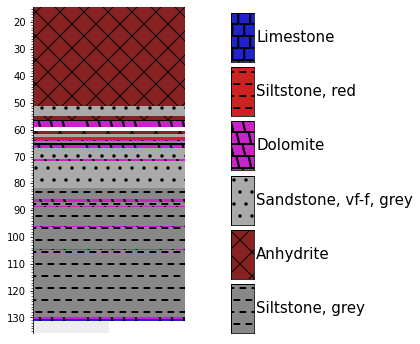

In [8]:
fix, ax = plt.subplots(ncols=2, figsize=(6,6))
bh3d.plot(legend=legend, ax=ax[0])
bh3d.legend.plot(ax=ax[1])

In [9]:
b = bh3d.intervals[0].base

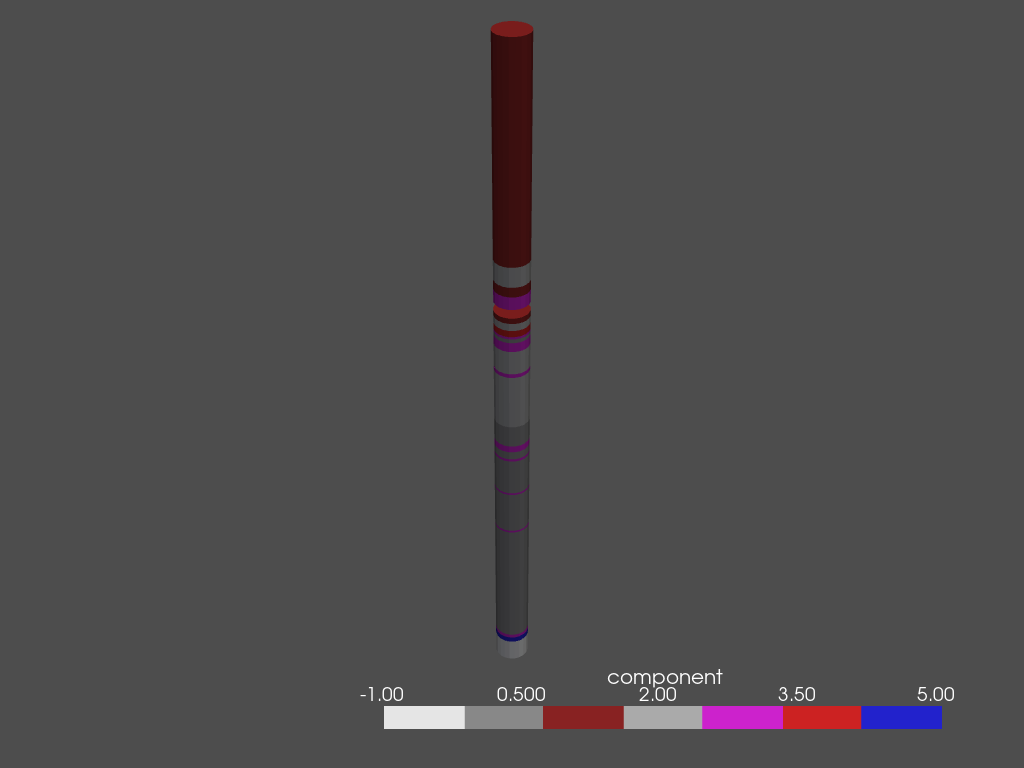

In [10]:
bh3d.plot3d()

In [11]:
def plot3d(x3d=False):
    omf_legend, omf_ = striplog_legend_to_omf_legend(bh.legend)
    pl = pv.Plotter()
    seg = ov.line_set_to_vtk(bh.geometry)
    seg.set_active_scalars('component')
    ov.lineset.add_data(seg, bh.geometry.data)
    pl.add_mesh(seg.tube(radius=3), cmap=bh.omf_cmap)
    if not x3d:
        pl.show()
    else:
        writer = vtkX3DExporter()
        writer.SetInput(pl.renderer.GetRenderWindow())
        filename = f'bh_{bh.name:s}.x3d'
        writer.SetFileName(filename)
        writer.Update()
        writer.Write()
        x3d_html = f'<html>\n<head>\n    <meta http-equiv="X-UA-Compatible" content="IE=edge"/>\n' \
                    '<title>X3D scene</title>\n <p>' \
                    '<script type=\'text/javascript\' src=\'http://www.x3dom.org/download/x3dom.js\'> </script>\n' \
                    '<link rel=\'stylesheet\' type=\'text/css\' href=\'http://www.x3dom.org/download/x3dom.css\'/>\n' \
                    '</head>\n<body>\n<p>\n For interaction, click in the view and press "a" to see the whole scene. For more info on interaction,' \
                    ' please read  <a href="https://doc.x3dom.org/tutorials/animationInteraction/navigation/index.html">the docs</a>  \n</p>\n' \
                    '<x3d width=\'968px\' height=\'600px\'>\n <scene>\n' \
                    '<viewpoint position="-1.94639 1.79771 -2.89271" orientation="0.03886 0.99185 0.12133 3.75685">' \
                    '</viewpoint>\n <Inline nameSpaceName="Borehole" mapDEFToID="true" url="'+filename+'" />\n' \
                    '</scene>\n</x3d>\n</body>\n</html>\n'
        return HTML(x3d_html)

In [12]:
bh3d.plot3d(x3d=True)

In [13]:
project = ov.load_project('omfproj.omf')

### Create the db engine and the database structure

In [14]:
engine = create_engine('sqlite:///tmp/test_orm_db.db', echo=True)

In [15]:
Base.metadata.create_all(engine)

2020-12-18 10:46:41,949 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-12-18 10:46:41,951 INFO sqlalchemy.engine.base.Engine ()
2020-12-18 10:46:41,962 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-12-18 10:46:41,964 INFO sqlalchemy.engine.base.Engine ()
2020-12-18 10:46:41,971 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("Boreholes")
2020-12-18 10:46:41,972 INFO sqlalchemy.engine.base.Engine ()
2020-12-18 10:46:41,977 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("Boreholes")
2020-12-18 10:46:41,978 INFO sqlalchemy.engine.base.Engine ()
2020-12-18 10:46:41,979 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("Intervals")
2020-12-18 10:46:41,980 INFO sqlalchemy.engine.base.Engine ()
2020-12-18 10:46:41,982 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("Intervals")
2020-12-18 10:46:41,982 INFO sqlalchemy.engine.base.Engine ()
2020-12-18

### Create the objects from text files (las, csv, txt)

In [16]:
lexicon = Lexicon.default()

In [17]:
borehole_dict = {'F01':'../data/test.las', 'F02':'../data/test.csv'} # boreholes to insert into the db

In [18]:
boreholes, components = boreholes_from_files(borehole_dict=borehole_dict)

File ../data/test.las OK! Creation of the striplog ...
File ../data/test.csv OK! Creation of the striplog ...


In [19]:
boreholes

### Create the ORM session

In [20]:
Session = sessionmaker(bind=engine)
session = Session()

### Create the ORM project

In [21]:
p = Project(session)

2020-12-18 10:46:42,096 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2020-12-18 10:46:42,098 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id" 
FROM "Boreholes"
2020-12-18 10:46:42,099 INFO sqlalchemy.engine.base.Engine ()


### Add boreholes into the database

In [22]:
for bh in boreholes:
    p.add_borehole(bh)

2020-12-18 10:46:42,114 INFO sqlalchemy.engine.base.Engine INSERT INTO "Boreholes" (id) VALUES (?)
2020-12-18 10:46:42,118 INFO sqlalchemy.engine.base.Engine ('F01',)
2020-12-18 10:46:42,121 INFO sqlalchemy.engine.base.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description) VALUES (?, ?, ?, ?)
2020-12-18 10:46:42,122 INFO sqlalchemy.engine.base.Engine ((0, 'F01', 0, 'Anhydrite'), (1, 'F01', 1, 'Sandstone, grey, vf-f'), (2, 'F01', 2, 'Anhydrite'), (3, 'F01', 3, 'Dolomite'), (4, 'F01', 4, 'Anhydrite'), (5, 'F01', 5, 'Sandstone, grey, vf-f'), (6, 'F01', 6, 'Siltstone, red'), (7, 'F01', 7, 'Dolomite')  ... displaying 10 of 25 total bound parameter sets ...  (23, 'F01', 23, 'Limestone'), (24, 'F01', 24, 'Volcanic'))
2020-12-18 10:46:42,127 INFO sqlalchemy.engine.base.Engine COMMIT
2020-12-18 10:46:42,133 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2020-12-18 10:46:42,139 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id" 
FROM "Boreholes"


In [23]:
p.boreholes[0].id

'F01'

In [24]:
p.boreholes[1].id='F33'

In [25]:
p.boreholes[1].id

'F33'

In [26]:
p.commit()

2020-12-18 10:46:42,229 INFO sqlalchemy.engine.base.Engine UPDATE "Boreholes" SET id=? WHERE "Boreholes".id = ?
2020-12-18 10:46:42,231 INFO sqlalchemy.engine.base.Engine ('F33', 'F02')
2020-12-18 10:46:42,234 INFO sqlalchemy.engine.base.Engine COMMIT


In [27]:
p.boreholes[0].intervals[0].description

2020-12-18 10:46:42,263 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2020-12-18 10:46:42,265 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2020-12-18 10:46:42,276 INFO sqlalchemy.engine.base.Engine ('F01',)
2020-12-18 10:46:42,282 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2020-12-18 10:46:42,289 INFO sqlalchemy.engine.base.Engine ('F01',)


'Anhydrite'

In [28]:
session.close()

2020-12-18 10:46:42,309 INFO sqlalchemy.engine.base.Engine ROLLBACK


### Test linking orm and omf : 
For now IntervalOrm do not have a base and a top -> adding them to the intervals retrieved from the boreholes in the sqlite database

In [29]:
bh3d.intervals[0].base.z


51.24117647058824

In [30]:
itvls = list(p.boreholes[0].intervals.values())

In [31]:
z=0.
dz=10.
itvls_list = []
for itvl in itvls:
    comp = Component(lexicon.get_component(itvl.description))
    top = Position(x=0., y=10., middle=z)
    z += dz
    base = Position(x=0., y=10., middle=z)
    itvls_list.append(Interval(top=top, base=base, components=[comp], description=itvl.description, lexicon=lexicon))

In [32]:
bh3d.intervals[0]

Interval({'top': Position({'middle': 14.3, 'units': 'm'}), 'base': Position({'middle': 51.24117647058824, 'units': 'm'}), 'description': 'Anhydrite', 'data': {}, 'components': [Component({'lithology': 'anhydrite'})]})

In [33]:
itv = Interval(top=top, base=base, components=[comp], description=itvl.description, lexicon=lexicon)

In [34]:
itv

Interval({'top': Position({'middle': 240.0, 'x': 0.0, 'y': 10.0, 'units': 'm'}), 'base': Position({'middle': 250.0, 'x': 0.0, 'y': 10.0, 'units': 'm'}), 'description': 'Volcanic', 'data': {}, 'components': [Component({})]})

In [35]:
type(bh3d.intervals[0])

striplog.interval.Interval

In [36]:
bh3d_2 = Borehole3D(itvls_list)

Borehole geometry created successfully !


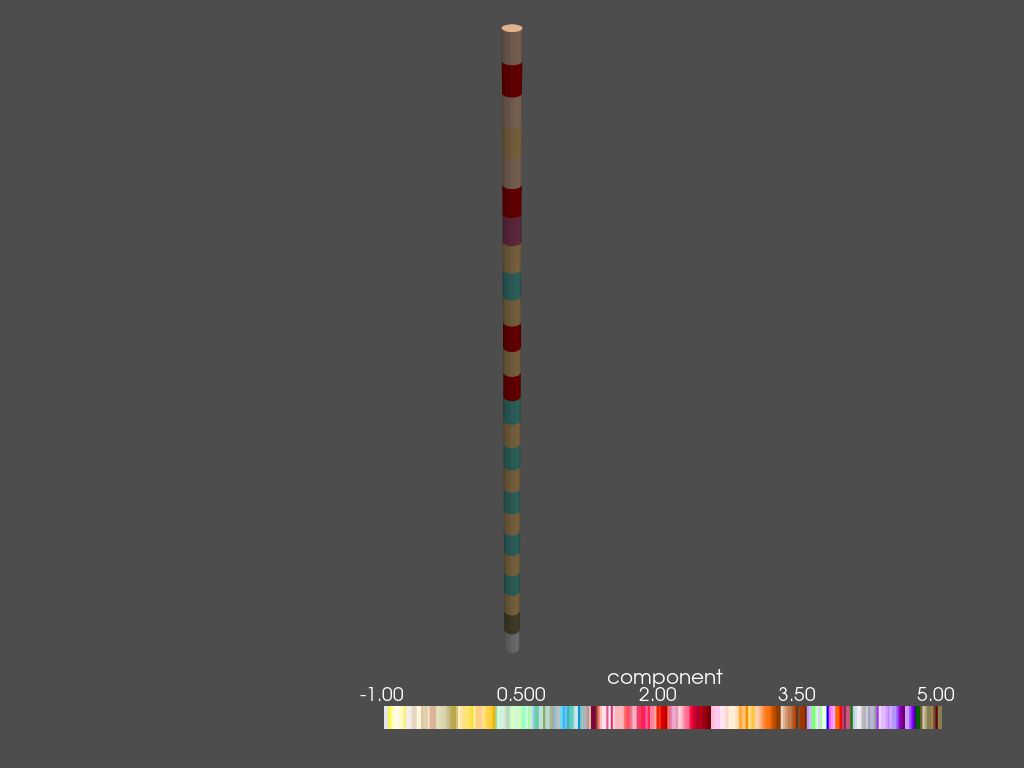

In [37]:
bh3d_2.plot3d()